In [1]:
import time, random
import numpy as np
import pennylane as qml
from qiskit import Aer, transpile, execute
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import random_clifford, Pauli, Statevector
import matplotlib.pyplot as plt

np.set_printoptions(precision=6, edgeitems=10, linewidth=150, suppress=True)

In [2]:
import qiskit
import itertools
from qiskit import *
from qiskit.quantum_info import Clifford, random_clifford
from qiskit.synthesis import synth_clifford_full
from qiskit.quantum_info import hellinger_fidelity as hf

from utils.pauli_checks import ChecksFinder, add_pauli_checks, add_meas_pauli_checks, add_linear_meas_pauli_checks,  search_for_pauli_list
from utils.pauli_checks import gen_initial_layout, gen_final_layout, rightchecks_postprocess, filter_results

from utils.utils import norm_dict, total_counts
from utils.vqe_utils import evaluation

In [3]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.25.2', 'qiskit': '0.44.2', 'qiskit-aer': '0.12.0', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

#### I. Calibrating $\tilde{f}$ in the noisy Clifford channel using hardware

In [3]:
total_trials = 1600
num_qubits = 4
def calibration_circuit(Clifford):
    qc = QuantumCircuit(num_qubits)
    
    clifford_circuit = Clifford.to_circuit()
    qc.compose(clifford_circuit, qubits=[0,1,2,3], inplace=True)
    
    qc.measure_all()
    return qc

In [4]:
cali_C_list = []
for i in range(total_trials):
    Clifford = random_clifford(4)
    cali_C_list.append(Clifford)
    
cali_circs = []
for i in range(total_trials):
    circuit = calibration_circuit(cali_C_list[i])
    cali_circs.append(circuit)

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
from qiskit.providers.fake_provider import FakeHanoi
from qiskit_aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise

service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q-ornl/anl/chm185")

# # Make a noise model
fake_backend = FakeHanoi()
# noise_model = NoiseModel.from_backend(fake_backend)

prob_1 = 0.003  # 1-qubit gate
prob_2 = 0.03   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)
#add the bitflit error.

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    
options = Options(optimization_level=2, resilience_level=1) # choose the proper levels on hardware
options.simulator = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
#     "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42
}
#backend = service.get_backend("") 
backend = "ibmq_qasm_simulator" # use the simulator for now

In [6]:
with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)
    
    # define physical qubits to be used in the layout arguement
    job = sampler.run(cali_circs, shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    
    result = job.result()
    
    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

Job ID: cmilmb2mpoeld4nchgi0
>>> Job Status: JobStatus.RUNNING


In [7]:
cali_b_lists = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits]: result.quasi_dists[i].binary_probabilities().get(key)})
    cali_b_lists.append(di)

In [8]:
len(cali_b_lists)

1600

In [9]:
cali_b_lists[-3]

{'0000': 0.05730438009772039,
 '0001': 0.05061641277787156,
 '0010': 0.062274827102077844,
 '0011': 0.07522170735161987,
 '0100': 0.05353764145710143,
 '0101': 0.053712680825387146,
 '0110': 0.0732506636113796,
 '0111': 0.060708721963288324,
 '1000': 0.06331106653723236,
 '1001': 0.05368838721876954,
 '1010': 0.056578280316671364,
 '1011': 0.060682798945765684,
 '1100': 0.06836745094674687,
 '1101': 0.06759501445898171,
 '1110': 0.07441469265510178,
 '1111': 0.06873527373428459}

In [10]:
def calibrating_f(cali_b_lists, cali_C_list, num_qubits):
    d = 2**num_qubits
    num_snapshots = len(cali_C_list)
    
    f_tilde = 0.
    for b_dict, clifford in zip(cali_b_lists, cali_C_list):
        F = computing_F(b_dict, clifford, num_qubits)
        f_tilde += np.real((d*F - 1) / (d - 1))
    
    return f_tilde / num_snapshots


def computing_F(b_dict, clifford, num_qubits):
    zero_state = state_reconstruction('0'*num_qubits)
    U = clifford.to_matrix()
    
    F = 0. + 0.j
    denom = 0.
    for b_state in list(b_dict.keys()):
        F += np.trace(zero_state @ U.T.conj() @ state_reconstruction(b_state) @ U) * b_dict.get(b_state)
        denom += b_dict.get(b_state)
    return F / denom


def state_reconstruction(b_str: str):
    '''
    '''
    zero_state = np.array([[1,0],[0,0]])
    one_state = np.array([[0,0], [0,1]])
    rho = [1]
    for i in b_str:
        state_i = zero_state if i=='0' else one_state
        rho = np.kron(rho, state_i)
    return rho

In [11]:
%%time

f_tilde = calibrating_f(cali_b_lists, cali_C_list, num_qubits)
print(f'The calibrated f_tilde is {f_tilde}; while the noiseless reference is {1/(2**num_qubits+1)}')

The calibrated f_tilde is 0.04422286283111791; while the noiseless reference is 0.058823529411764705
CPU times: user 16.4 s, sys: 43 ms, total: 16.5 s
Wall time: 16.5 s


#### II. Perform the standard shadow experiments

In [12]:
# define the ansatz circuit

# num_checks = 4
# num_qubits = 4
# total_qubits = num_checks + num_qubits
def hydrogen_trial_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    # prepare the Hartree-Fock state
    qc.x(0)
    qc.x(1)
    
    qc.rx(np.pi/2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    
    qc.cx(0,1)
    qc.cx(1,2)
    qc.cx(2,3)
    
    qc.rz(1.0, 3)
    
    qc.cx(2,3)
    qc.cx(1,2)
    qc.cx(0,1)
    
    qc.rx(-np.pi/2, 0)
    qc.h(1)
    qc.h(2)
    qc.h(3)
    
    return qc


def hydrogen_shadow_circuit(Clifford, num_qubits):
    qc = hydrogen_trial_circuit(num_qubits)
    
    clifford_circuit = Clifford.to_circuit()
    qc.compose(clifford_circuit, qubits=[0,1,2,3], inplace=True)
    
    qc.measure_all()
    return qc

def hydrogen_shadow_PCS_circuit(Clifford, num_qubits, num_checks, single_side = False):
    total_qubits = num_qubits + num_checks
    qc = hydrogen_trial_circuit(total_qubits)

    clif_qc = Clifford.to_circuit()
    
    characters = ['I', 'Z']
    strings = [''.join(p) for p in itertools.product(characters, repeat=num_qubits)]
    
    test_finder = ChecksFinder(num_qubits, clif_qc)
    p1_list = []
    for string in strings:
        string_list = list(string)
        result = test_finder.find_checks_sym(pauli_group_elem = string_list)
        #print(result.p1_str, result.p2_str)
        p1_list.append([result.p1_str, result.p2_str])
        
    sorted_list = sorted(p1_list, key=lambda s: s[1].count('I'))
    pauli_list = sorted_list[-num_qubits -1:-1]
    
    #
    initial_layout = {}
    for i in range(0, num_qubits):
        initial_layout[i] = [i]

    final_layout = {}
    for i in range(0, num_qubits):
        final_layout[i] = [i]
        
    #add pauli check on two sides:
    #specify the left and right pauli strings
    pcs_qc_list = []
    sign_list = []
    pl_list = []
    pr_list = []

    for i in range(0, num_checks):
        pl = pauli_list[i][0][2:]
        pr = pauli_list[i][1][2:]
        if i == 0:
            temp_qc = add_pauli_checks(clif_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False)
            save_qc = add_pauli_checks(clif_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False)
            prev_qc = temp_qc
        else:
            temp_qc = add_pauli_checks(prev_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False)
            save_qc = add_pauli_checks(prev_qc, pl, pr, initial_layout, final_layout, False, single_side, False, False, False) 
            prev_qc = temp_qc
        pl_list.append(pl)
        pr_list.append(pr)
        sign_list.append(pauli_list[i][0][:2])
        pcs_qc_list.append(save_qc)

    
    qc.compose(pcs_qc_list[-1], qubits=[i for i in range(0, total_qubits)], inplace=True)
    
    qc.measure_all()
    return qc, (sign_list, pl_list, pr_list)



In [13]:
num_qubits = 4
num_checks = 4
C_list = []
for i in range(total_trials):
    Clifford = random_clifford(4)
    C_list.append(Clifford)
circs_list = []
checks_list = []
for check_id in range(1, num_checks + 1):
    circs = []
    checks = []
    for i in range(total_trials):
        circ, check = hydrogen_shadow_PCS_circuit(C_list[i], num_qubits, check_id, True)
        circs.append(circ)
        checks.append(check)
    circs_list.append(circs)
    checks_list.append(checks)
    
orign_circs = []
for i in range(total_trials):
    circuit = hydrogen_shadow_circuit(C_list[i], num_qubits)
    orign_circs.append(circuit)

In [14]:
checks_list[1]

[(['+1', '+1'], ['ZXXX', 'ZIZZ'], ['IIIZ', 'IIZI']),
 (['+1', '+1'], ['ZYYY', 'XYIZ'], ['IIIZ', 'IIZI']),
 (['-1', '+1'], ['YIXY', 'IZZX'], ['IIIZ', 'IIZI']),
 (['-1', '+1'], ['XZYZ', 'IYXZ'], ['IIIZ', 'IIZI']),
 (['+1', '+1'], ['YIXI', 'XZZZ'], ['IIIZ', 'IIZI']),
 (['-1', '-1'], ['XYII', 'ZXIY'], ['IIIZ', 'IIZI']),
 (['-1', '+1'], ['IIZY', 'ZXIY'], ['IIIZ', 'IIZI']),
 (['+1', '-1'], ['ZIZX', 'YZIY'], ['IIIZ', 'IIZI']),
 (['+1', '+1'], ['YYYZ', 'XIIY'], ['IIIZ', 'IIZI']),
 (['+1', '-1'], ['YIYY', 'ZZZY'], ['IIIZ', 'IIZI']),
 (['+1', '-1'], ['IZIY', 'IXIX'], ['IIIZ', 'IIZI']),
 (['-1', '+1'], ['IXIZ', 'IIXZ'], ['IIIZ', 'IIZI']),
 (['-1', '+1'], ['ZIII', 'ZYZY'], ['IIIZ', 'IIZI']),
 (['-1', '+1'], ['YZXI', 'YIXY'], ['IIIZ', 'IIZI']),
 (['-1', '+1'], ['YYZZ', 'ZYXZ'], ['IIIZ', 'IIZI']),
 (['+1', '+1'], ['IIXZ', 'ZXII'], ['IIIZ', 'IIZI']),
 (['-1', '+1'], ['IZZI', 'IXYI'], ['IIIZ', 'IIZI']),
 (['-1', '+1'], ['ZYIZ', 'IIYZ'], ['IIIZ', 'IIZI']),
 (['+1', '-1'], ['IXYZ', 'XYZZ'], ['IIIZ', 'II

In [15]:
len(circs_list)

4

In [16]:
circs_list[3][-1].draw()

┌───┐┌─────────┐                                       ┌──────────┐   »
   q_0: ┤ X ├┤ Rx(π/2) ├──■─────────────────────────────────■──┤ Rx(-π/2) ├─■─»
        ├───┤└──┬───┬──┘┌─┴─┐                             ┌─┴─┐└──┬───┬───┘ │ »
   q_1: ┤ X ├───┤ H ├───┤ X ├──■───────────────────────■──┤ X ├───┤ H ├─────┼─»
        ├───┤   └───┘   └───┘┌─┴─┐                   ┌─┴─┐├───┤   └───┘     │ »
   q_2: ┤ H ├────────────────┤ X ├──■─────────────■──┤ X ├┤ H ├─────────────┼─»
        ├───┤                └───┘┌─┴─┐┌───────┐┌─┴─┐├───┤└───┘             │ »
   q_3: ┤ H ├─────────────────────┤ X ├┤ Rz(1) ├┤ X ├┤ H ├──────────────────┼─»
        ├───┤                     └───┘└───────┘└───┘└───┘                  │ »
   q_4: ┤ H ├───────────────────────────────────────────────────────────────┼─»
        ├───┤                                                               │ »
   q_5: ┤ H ├───────────────────────────────────────────────────────────────┼─»
        ├───┤                                                               │ »
   q_6: ┤ H ├───────────────────────────────────────────────────────────────┼─»
        ├───┤                                                               │ »
   q_7: ┤ H ├───────────────────────────────────────────────────────────────■─»
        └───┘                                                                 »
meas: 8/══════════════════════════════════════════════════════════════════════»
                                                                              »
«             ┌───┐                     ┌───┐┌───┐                            »
«   q_0: ─────┤ X ├─────────■───────────┤ X ├┤ H ├────────────────────────────»
«        ┌───┐└─┬─┘   ┌───┐ │ ┌───┐┌───┐└─┬─┘├───┤                            »
«   q_1: ┤ Y ├──┼─────┤ Y ├─┼─┤ S ├┤ H ├──┼──┤ S ├────────────────────────────»
«        └─┬─┘  │     └─┬─┘ │ └───┘├───┤  │  └───┘        ┌───┐┌───┐┌───┐┌───┐»
«   q_2: ──┼────┼───■───┼───┼──────┤ Y ├──┼─────────■─────┤ Y ├┤ S ├┤ H ├┤ S ├»
«          │    │   │   │   │      └─┬─┘  │         │     └─┬─┘├───┤└───┘└───┘»
«   q_3: ──┼────┼───┼───┼───┼───■────┼────┼────■────┼───■───┼──┤ S ├──────────»
«          │    │   │   │   │   │    │    │    │    │   │   │  ├───┤          »
«   q_4: ──┼────┼───┼───┼───┼───┼────┼────■────┼────┼───┼───■──┤ H ├──────────»
«          │    │   │   │   │   │    │         │    │   │ ┌───┐└───┘          »
«   q_5: ──┼────┼───┼───┼───■───┼────┼─────────┼────■───■─┤ H ├───────────────»
«          │    │   │   │       │    │         │  ┌───┐   └───┘               »
«   q_6: ──┼────■───┼───■───────┼────■─────────■──┤ H ├───────────────────────»
«          │        │           │  ┌───┐          └───┘                       »
«   q_7: ──■────────■───────────■──┤ H ├──────────────────────────────────────»
«                                  └───┘                                      »
«meas: 8/═════════════════════════════════════════════════════════════════════»
«                                                                             »
«                ┌───┐┌───┐                                                »
«   q_0: ─X───■──┤ X ├┤ X ├────────────────────────────────────────────────»
«         │   │  └─┬─┘└───┘                                      ┌───┐┌───┐»
«   q_1: ─┼───┼────┼────────X───■────────────────────────■───────┤ X ├┤ Y ├»
«         │   │    │        │   │  ┌───┐┌───┐     ┌───┐┌─┴─┐┌───┐└─┬─┘├───┤»
«   q_2: ─X───┼────■────────┼───┼──┤ X ├┤ H ├──■──┤ H ├┤ X ├┤ H ├──■──┤ H ├»
«           ┌─┴─┐┌───┐┌───┐ │ ┌─┴─┐└─┬─┘└───┘┌─┴─┐├───┤└───┘└───┘     └───┘»
«   q_3: ───┤ X ├┤ S ├┤ H ├─X─┤ X ├──■───────┤ X ├┤ Z ├────────────────────»
«           └───┘└───┘└───┘   └───┘          └───┘└───┘                    »
«   q_4: ──────────────────────────────────────────────────────────────────»
«                                                                          »
«   q_5: ──────────────────────────────────────────────────────────────────»
«                                           

In [17]:
circs_list[1][-1].draw()

┌───┐┌─────────┐                                       ┌──────────┐   »
   q_0: ┤ X ├┤ Rx(π/2) ├──■─────────────────────────────────■──┤ Rx(-π/2) ├─■─»
        ├───┤└──┬───┬──┘┌─┴─┐                             ┌─┴─┐└──┬───┬───┘ │ »
   q_1: ┤ X ├───┤ H ├───┤ X ├──■───────────────────────■──┤ X ├───┤ H ├─────┼─»
        ├───┤   └───┘   └───┘┌─┴─┐                   ┌─┴─┐├───┤   └───┘     │ »
   q_2: ┤ H ├────────────────┤ X ├──■─────────────■──┤ X ├┤ H ├─────────────┼─»
        ├───┤                └───┘┌─┴─┐┌───────┐┌─┴─┐├───┤└───┘             │ »
   q_3: ┤ H ├─────────────────────┤ X ├┤ Rz(1) ├┤ X ├┤ H ├──────────────────┼─»
        ├───┤                     └───┘└───────┘└───┘└───┘                  │ »
   q_4: ┤ H ├───────────────────────────────────────────────────────────────┼─»
        ├───┤                                                               │ »
   q_5: ┤ H ├───────────────────────────────────────────────────────────────■─»
        └───┘                                                                 »
meas: 6/══════════════════════════════════════════════════════════════════════»
                                                                              »
«             ┌───┐┌───┐                            ┌───┐┌───┐             »
«   q_0: ─────┤ X ├┤ H ├─────────────────────X───■──┤ X ├┤ X ├─────────────»
«        ┌───┐└─┬─┘├───┤┌───┐                │   │  └─┬─┘└───┘             »
«   q_1: ┤ S ├──┼──┤ H ├┤ S ├────────────────┼───┼────┼────────X───■───────»
«        └───┘  │  └───┘├───┤┌───┐┌───┐┌───┐ │   │    │        │   │  ┌───┐»
«   q_2: ──■────┼───────┤ Y ├┤ S ├┤ H ├┤ S ├─X───┼────■────────┼───┼──┤ X ├»
«          │    │       └─┬─┘├───┤└───┘└───┘   ┌─┴─┐┌───┐┌───┐ │ ┌─┴─┐└─┬─┘»
«   q_3: ──┼────┼────■────┼──┤ S ├─────────────┤ X ├┤ S ├┤ H ├─X─┤ X ├──■──»
«          │    │    │    │  ├───┤             └───┘└───┘└───┘   └───┘     »
«   q_4: ──┼────■────┼────■──┤ H ├─────────────────────────────────────────»
«          │         │  ┌───┐└───┘                                         »
«   q_5: ──■─────────■──┤ H ├──────────────────────────────────────────────»
«                       └───┘                                              »
«meas: 6/══════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                 ░ ┌─┐               
«   q_0: ─────────────────────────────────────────░─┤M├───────────────
«                                 ┌───┐┌───┐      ░ └╥┘┌─┐            
«   q_1: ─────────────────■───────┤ X ├┤ Y ├──────░──╫─┤M├────────────
«        ┌───┐     ┌───┐┌─┴─┐┌───┐└─┬─┘├───┤┌───┐ ░  ║ └╥┘┌─┐         
«   q_2: ┤ H ├──■──┤ H ├┤ X ├┤ H ├──■──┤ H ├┤ S ├─░──╫──╫─┤M├─────────
«        └───┘┌─┴─┐├───┤└───┘└───┘     └───┘└───┘ ░  ║  ║ └╥┘┌─┐      
«   q_3: ─────┤ X ├┤ Z ├──────────────────────────░──╫──╫──╫─┤M├──────
«             └───┘└───┘                          ░  ║  ║  ║ └╥┘┌─┐   
«   q_4: ─────────────────────────────────────────░──╫──╫──╫──╫─┤M├───
«                                                 ░  ║  ║  ║  ║ └╥┘┌─┐
«   q_5: ─────────────────────────────────────────░──╫──╫──╫──╫──╫─┤M├
«                                                 ░  ║  ║  ║  ║  ║ └╥┘
«meas: 6/════════════════════════════════════════════╩══╩══╩══╩══╩══╩═
«                                                    0  1  2  3  4  5

In [18]:
# def runtime_check_experiment(service, backend, circuits):
#     session = Session(service, backend=backend)
#     sampler = Sampler(session=session, options=options)

#     # same as the calibration process
#     job = sampler.run(circs, shots=1024, initial_layout=[])
#     print(f"Job ID: {job.job_id()}")
#     print(f">>> Job Status: {job.status()}")

#     result = job.result()

#     # Close the session only if all jobs are finished
#     # and you don't need to run more in the session.
#     session.close()
        
#     b_lists_check = []
#     for i in range(total_trials):
#         di = {}
#         for key in list(result.quasi_dists[i].binary_probabilities().keys()):
#             di.update({key[:total_qubits]: result.quasi_dists[i].binary_probabilities().get(key)})
#         b_lists_check.append(di)
        
#     filtered_b_lists = []
#     for i in range(total_trials):
#         bit_list = ['1' if i == '+1' else '0' for i in signs_list[i][num_checks - 1::-1]]
#     #     print(bit_list)
#         filted_dist = filter_results_reindex(b_lists_check[i], total_qubits-num_checks, [j for j in range(0, num_checks)], bit_list)
#         print(total_counts(filted_dist))
#         filtered_b_lists.append(filted_dist)
#     return filtered_b_lists

In [19]:
def filter_results_reindex(dictionary, qubits, indexes, sign_list):
    new_dict = {}
    for key in dictionary.keys():
        new_key = ''
        for i in range(len(key)):
            meas_index = i
#             if i < len(sign_list):
#                 print(key, "index", i, key[i], sign_list[meas_index])
            if meas_index in indexes and key[i] == sign_list[meas_index]:
                #the key equals the sign, keep
                new_key = ''
                break
            if meas_index not in indexes:
                new_key += key[i]
        if new_key != '':
            new_dict[new_key] = dictionary[key]
    return new_dict

In [20]:
from utils.pauli_checks import update_cnot_dist
def singlecheck_postprocess(input_dict, right_checks, qubits, check_count, layer_index):
    output_dict = input_dict.copy()
    for index in range(0, len(right_checks)):
        check = right_checks[index]
        if check == 'Z':
            ctrl_index =  - qubits + index 
            targ_index = check_count - layer_index -1
            output_dict = update_cnot_dist(output_dict, ctrl_index, targ_index)
            #change the corresponding qubit in the distribution
    return output_dict

def rightchecks_postprocess(input_dist, qubits, check_count, pr_list):
    output_dict = input_dist
    for i in range(0, check_count):
        output_dict = singlecheck_postprocess(output_dict, right_checks = pr_list[i], qubits = qubits, check_count = check_count, layer_index = i)
    return output_dict 

In [21]:
b_lists_filtered = []
check_id = 1
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run(circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_check.append(di)


filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in checks_list[check_id-1][i][0][check_id - 1::-1]]
#     print(bit_list)
    output_dist = rightchecks_postprocess(b_lists_check[i], num_qubits, check_id, pr_list = checks_list[check_id - 1][i][2])
    filted_dist = filter_results_reindex(output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
    print(total_counts(filted_dist))
    filtered_b_lists.append(filted_dist)
b_lists_filtered.append(filtered_b_lists)


Job ID: cmilp32mpoeld4nchubg
>>> Job Status: JobStatus.RUNNING
0.8084899024153784
0.8956443594801899
0.7830743738540972
0.8173267387566163
0.7967802654232088
0.8349548148403639
0.9113229562277708
0.9162279334615914
0.8603993330818576
0.8996113229905516
0.9211289523034447
0.9309379669235827
0.9065006012749257
0.8104550484642166
0.8623832048971031
0.7996336726362224
0.8779336611154667
0.8143815047727677
0.8084747807713757
0.9035463978526793
0.8711621810960174
0.8290962763885142
0.8839339764660229
0.9191819801828637
0.9172166774330517
0.8712155002948324
0.9132772524265215
0.8476766225996248
0.9083720026583666
0.8985890041430151
0.9260482642916563
0.7820478274650007
0.8447474504656236
0.9005664137354487
0.9044869154069833
0.8966780374559796
0.8720673250977841
0.8447940315225516
0.8408654188832358
0.8143758635376993
0.8399092312315196
0.8652980388919722
0.8761226304746768
0.8153903473365295
0.838859333012538
0.9248530212494884
0.815375695795449
0.8260994094336926
0.8016839481816224
0.877064

In [22]:
b_lists_check[1]

{'00000': 0.01630850658034292,
 '00001': 0.0018854676297779549,
 '00010': 0.07412427834819839,
 '00011': 0.019437697956460522,
 '00100': 0.11619502128451738,
 '00101': 0.015520184932171048,
 '00110': 0.014658552674711911,
 '00111': 0.0039052488145775266,
 '01000': 0.014381881095120029,
 '01001': 0.0028850971427440675,
 '01010': 0.09296194471795617,
 '01011': 0.006711083496246675,
 '01100': 0.11160279047137045,
 '01101': 0.010646023392473714,
 '01110': 0.01566927568077553,
 '01111': 0.0068542545147807525,
 '10000': 0.005830774087058778,
 '10001': 0.01441121741288886,
 '10010': 0.004746952949502431,
 '10011': 0.09300684070368456,
 '10100': 0.0037670322941833903,
 '10101': 0.0950107182979403,
 '10110': 0.0019446458929842164,
 '10111': 0.005873895327445888,
 '11000': 0.0028918262041398245,
 '11001': 0.02033060044240732,
 '11010': 0.005723577058173452,
 '11011': 0.10110596711897238,
 '11100': 0.005735025416256625,
 '11101': 0.09623654171835327,
 '11110': 0.005870748738278915,
 '11111': 0.01

In [23]:
output_dist = rightchecks_postprocess(b_lists_check[1], num_qubits, check_id, pr_list = checks_list[check_id - 1][1][2])
output_dist

{'00000': 0.01630850658034292,
 '10001': 0.0018854676297779549,
 '00010': 0.07412427834819839,
 '10011': 0.019437697956460522,
 '00100': 0.11619502128451738,
 '10101': 0.015520184932171048,
 '00110': 0.014658552674711911,
 '10111': 0.0039052488145775266,
 '01000': 0.014381881095120029,
 '11001': 0.0028850971427440675,
 '01010': 0.09296194471795617,
 '11011': 0.006711083496246675,
 '01100': 0.11160279047137045,
 '11101': 0.010646023392473714,
 '01110': 0.01566927568077553,
 '11111': 0.0068542545147807525,
 '10000': 0.005830774087058778,
 '00001': 0.01441121741288886,
 '10010': 0.004746952949502431,
 '00011': 0.09300684070368456,
 '10100': 0.0037670322941833903,
 '00101': 0.0950107182979403,
 '10110': 0.0019446458929842164,
 '00111': 0.005873895327445888,
 '11000': 0.0028918262041398245,
 '01001': 0.02033060044240732,
 '11010': 0.005723577058173452,
 '01011': 0.10110596711897238,
 '11100': 0.005735025416256625,
 '01101': 0.09623654171835327,
 '11110': 0.005870748738278915,
 '01111': 0.01

In [24]:
circs_list[0][1].draw()

┌───┐┌─────────┐                                       ┌──────────┐»
   q_0: ┤ X ├┤ Rx(π/2) ├──■─────────────────────────────────■──┤ Rx(-π/2) ├»
        ├───┤└──┬───┬──┘┌─┴─┐                             ┌─┴─┐└──┬───┬───┘»
   q_1: ┤ X ├───┤ H ├───┤ X ├──■───────────────────────■──┤ X ├───┤ H ├────»
        ├───┤   └───┘   └───┘┌─┴─┐                   ┌─┴─┐├───┤   └───┘    »
   q_2: ┤ H ├────────────────┤ X ├──■─────────────■──┤ X ├┤ H ├────────────»
        ├───┤                └───┘┌─┴─┐┌───────┐┌─┴─┐├───┤└───┘            »
   q_3: ┤ H ├─────────────────────┤ X ├┤ Rz(1) ├┤ X ├┤ H ├─────────────────»
        ├───┤                     └───┘└───────┘└───┘└───┘                 »
   q_4: ┤ H ├──────────────────────────────────────────────────────────────»
        └───┘                                                              »
meas: 5/═══════════════════════════════════════════════════════════════════»
                                                                           »
«        ┌───┐┌───┐┌───┐     ┌───┐┌───┐     ┌───┐┌───┐                       »
«   q_0: ┤ Y ├┤ S ├┤ H ├─────┤ X ├┤ X ├─────┤ X ├┤ Y ├───────────────────────»
«        └─┬─┘├───┤├───┤┌───┐└─┬─┘└─┬─┘┌───┐└─┬─┘├───┤     ┌───┐             »
«   q_1: ──┼──┤ Y ├┤ S ├┤ H ├──■────┼──┤ H ├──┼──┤ S ├─────┤ X ├──■────────X─»
«          │  └─┬─┘├───┤├───┤┌───┐  │  ├───┤  │  └───┘     └─┬─┘┌─┴─┐      │ »
«   q_2: ──┼────┼──┤ Y ├┤ S ├┤ H ├──■──┤ S ├──┼──────────────┼──┤ X ├──■───┼─»
«          │    │  └─┬─┘└───┘└───┘     └───┘  │  ┌───┐┌───┐  │  └───┘┌─┴─┐ │ »
«   q_3: ──┼────┼────┼────■───────────────────■──┤ H ├┤ S ├──■───────┤ X ├─X─»
«          │    │    │    │  ┌───┐               └───┘└───┘          └───┘   »
«   q_4: ──■────■────■────■──┤ H ├───────────────────────────────────────────»
«                            └───┘                                           »
«meas: 5/════════════════════════════════════════════════════════════════════»
«                                                                            »
«                        ░ ┌─┐            
«   q_0: ────────────────░─┤M├────────────
«        ┌───┐┌───┐┌───┐ ░ └╥┘┌─┐         
«   q_1: ┤ X ├┤ S ├┤ X ├─░──╫─┤M├─────────
«        └─┬─┘└───┘└───┘ ░  ║ └╥┘┌─┐      
«   q_2: ──┼─────────────░──╫──╫─┤M├──────
«          │  ┌───┐      ░  ║  ║ └╥┘┌─┐   
«   q_3: ──■──┤ Z ├──────░──╫──╫──╫─┤M├───
«             └───┘      ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ────────────────░──╫──╫──╫──╫─┤M├
«                        ░  ║  ║  ║  ║ └╥┘
«meas: 5/═══════════════════╩══╩══╩══╩══╩═
«                           0  1  2  3  4

In [25]:
bit_list = ['1' if i == '+1' else '0' for i in checks_list[check_id-1][1][0][check_id - 1::-1]]
bit_list

['1']

In [26]:
filted_dist = filter_results_reindex(output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
filted_dist

{'0000': 0.01630850658034292,
 '0010': 0.07412427834819839,
 '0100': 0.11619502128451738,
 '0110': 0.014658552674711911,
 '1000': 0.014381881095120029,
 '1010': 0.09296194471795617,
 '1100': 0.11160279047137045,
 '1110': 0.01566927568077553,
 '0001': 0.01441121741288886,
 '0011': 0.09300684070368456,
 '0101': 0.0950107182979403,
 '0111': 0.005873895327445888,
 '1001': 0.02033060044240732,
 '1011': 0.10110596711897238,
 '1101': 0.09623654171835327,
 '1111': 0.013766327605504624}

In [27]:
check_id = 2
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run(circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_check.append(di)


filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in checks_list[check_id-1][i][0][check_id - 1::-1]]
#     print(bit_list)
    output_dist = rightchecks_postprocess(b_lists_check[i], num_qubits, check_id, pr_list = checks_list[check_id - 1][i][2])
    filted_dist = filter_results_reindex(output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
    print(total_counts(filted_dist))
    filtered_b_lists.append(filted_dist)
b_lists_filtered.append(filtered_b_lists)


Job ID: cmilqpimpoeld4nci590
>>> Job Status: JobStatus.RUNNING
0.7415410524364048
0.736015266595883
0.6713719722679796
0.7174228719362469
0.7105248052300291
0.6937804656512324
0.791853507141052
0.7536350753799792
0.7830216693601103
0.7506595055915964
0.8611966978174856
0.8789163607896271
0.7359258159440177
0.750716636848098
0.7066071573396675
0.6908932972583214
0.7953894328592913
0.7203282988388475
0.7252769411121944
0.7752225277454149
0.7477940744139817
0.6703894253449221
0.7948011405992406
0.7595180061201815
0.8417750669484164
0.7105600963289231
0.7394694174085208
0.7419221166701665
0.7468219522494753
0.7418474724106732
0.7251060610779261
0.6948247289900843
0.6912089213100124
0.7722901924779046
0.7878583206360861
0.7773273959754561
0.6967589259990421
0.7517598434476065
0.7252500482162799
0.7164109984477441
0.7007694792370283
0.7301401132430467
0.7556138422510302
0.6762426323791286
0.7633101010925839
0.7760524227240242
0.7525770483630557
0.692825254792283
0.7222998419690795
0.80358609

In [28]:
circs_list[2-1][-1].draw()

┌───┐┌─────────┐                                       ┌──────────┐   »
   q_0: ┤ X ├┤ Rx(π/2) ├──■─────────────────────────────────■──┤ Rx(-π/2) ├─■─»
        ├───┤└──┬───┬──┘┌─┴─┐                             ┌─┴─┐└──┬───┬───┘ │ »
   q_1: ┤ X ├───┤ H ├───┤ X ├──■───────────────────────■──┤ X ├───┤ H ├─────┼─»
        ├───┤   └───┘   └───┘┌─┴─┐                   ┌─┴─┐├───┤   └───┘     │ »
   q_2: ┤ H ├────────────────┤ X ├──■─────────────■──┤ X ├┤ H ├─────────────┼─»
        ├───┤                └───┘┌─┴─┐┌───────┐┌─┴─┐├───┤└───┘             │ »
   q_3: ┤ H ├─────────────────────┤ X ├┤ Rz(1) ├┤ X ├┤ H ├──────────────────┼─»
        ├───┤                     └───┘└───────┘└───┘└───┘                  │ »
   q_4: ┤ H ├───────────────────────────────────────────────────────────────┼─»
        ├───┤                                                               │ »
   q_5: ┤ H ├───────────────────────────────────────────────────────────────■─»
        └───┘                                                                 »
meas: 6/══════════════════════════════════════════════════════════════════════»
                                                                              »
«             ┌───┐┌───┐                            ┌───┐┌───┐             »
«   q_0: ─────┤ X ├┤ H ├─────────────────────X───■──┤ X ├┤ X ├─────────────»
«        ┌───┐└─┬─┘├───┤┌───┐                │   │  └─┬─┘└───┘             »
«   q_1: ┤ S ├──┼──┤ H ├┤ S ├────────────────┼───┼────┼────────X───■───────»
«        └───┘  │  └───┘├───┤┌───┐┌───┐┌───┐ │   │    │        │   │  ┌───┐»
«   q_2: ──■────┼───────┤ Y ├┤ S ├┤ H ├┤ S ├─X───┼────■────────┼───┼──┤ X ├»
«          │    │       └─┬─┘├───┤└───┘└───┘   ┌─┴─┐┌───┐┌───┐ │ ┌─┴─┐└─┬─┘»
«   q_3: ──┼────┼────■────┼──┤ S ├─────────────┤ X ├┤ S ├┤ H ├─X─┤ X ├──■──»
«          │    │    │    │  ├───┤             └───┘└───┘└───┘   └───┘     »
«   q_4: ──┼────■────┼────■──┤ H ├─────────────────────────────────────────»
«          │         │  ┌───┐└───┘                                         »
«   q_5: ──■─────────■──┤ H ├──────────────────────────────────────────────»
«                       └───┘                                              »
«meas: 6/══════════════════════════════════════════════════════════════════»
«                                                                          »
«                                                 ░ ┌─┐               
«   q_0: ─────────────────────────────────────────░─┤M├───────────────
«                                 ┌───┐┌───┐      ░ └╥┘┌─┐            
«   q_1: ─────────────────■───────┤ X ├┤ Y ├──────░──╫─┤M├────────────
«        ┌───┐     ┌───┐┌─┴─┐┌───┐└─┬─┘├───┤┌───┐ ░  ║ └╥┘┌─┐         
«   q_2: ┤ H ├──■──┤ H ├┤ X ├┤ H ├──■──┤ H ├┤ S ├─░──╫──╫─┤M├─────────
«        └───┘┌─┴─┐├───┤└───┘└───┘     └───┘└───┘ ░  ║  ║ └╥┘┌─┐      
«   q_3: ─────┤ X ├┤ Z ├──────────────────────────░──╫──╫──╫─┤M├──────
«             └───┘└───┘                          ░  ║  ║  ║ └╥┘┌─┐   
«   q_4: ─────────────────────────────────────────░──╫──╫──╫──╫─┤M├───
«                                                 ░  ║  ║  ║  ║ └╥┘┌─┐
«   q_5: ─────────────────────────────────────────░──╫──╫──╫──╫──╫─┤M├
«                                                 ░  ║  ║  ║  ║  ║ └╥┘
«meas: 6/════════════════════════════════════════════╩══╩══╩══╩══╩══╩═
«                                                    0  1  2  3  4  5

In [29]:
bit_list

['1', '1']

In [30]:
checks_list[1][i]

(['+1', '+1'], ['IYIX', 'ZZIZ'], ['IIIZ', 'IIZI'])

In [31]:
b_lists_check[0]

{'000000': 0.10717490628650633,
 '000001': 0.013458171554122147,
 '000010': 0.002878166680619703,
 '000011': 0.008781695937300691,
 '000100': 0.12513207570788218,
 '000101': 0.011551370648077857,
 '000110': 0.003869486278044593,
 '000111': 0.007815815167458653,
 '001000': 0.008750502059492822,
 '001001': 0.003876363741701326,
 '001010': 0.007754893003210712,
 '001011': 0.005853979803573567,
 '001100': 0.01564699438769414,
 '001101': 0.005855511438946416,
 '001110': 0.00678872683121131,
 '001111': 0.008825765804647034,
 '010000': 0.010515227121718304,
 '010001': 0.14177477528295232,
 '010010': 0.012690844963814259,
 '010011': 0.00781497674217837,
 '010100': 0.0046883329708599375,
 '010101': 0.1294377686531001,
 '010110': 0.01173630377941061,
 '010111': 0.011768414011880377,
 '011000': 0.005841920903135341,
 '011001': 0.014680547906939078,
 '011010': 0.004869972617500136,
 '011011': 0.006813622622791712,
 '011100': 0.0009481679467991703,
 '011101': 0.012759110119822739,
 '011110': 0.0098

In [32]:
b_lists_check[i]

{'000000': 0.011591167230402977,
 '000001': 0.001879057247844918,
 '000010': 0.00486050281311864,
 '000011': 0.0009557578252317127,
 '000100': 0.03320124187419038,
 '000101': 0.000946557532808185,
 '000110': 0.0057135354590826986,
 '001000': 0.03515332434166244,
 '001001': 0.0029052452476662394,
 '001010': 0.004758411389657683,
 '001011': 0.0019458002938167512,
 '001100': 0.014667610861535084,
 '001101': 0.0009237885106536652,
 '001110': 0.00488651941016387,
 '001111': 0.0019473037881087454,
 '010000': 0.0028427950145916,
 '010001': 0.047920944250591305,
 '010010': 0.0009566270448954079,
 '010011': 0.011606036204446488,
 '010100': 0.004870700617535419,
 '010101': 0.013665753510520127,
 '010110': 0.0019511111917602387,
 '010111': 0.0019318995517018315,
 '011000': 0.0009467987204121165,
 '011001': 0.016583702417712298,
 '011011': 0.007819043351632016,
 '011100': 0.002872965877984476,
 '011101': 0.038280782742766827,
 '011110': 0.0019462194636865708,
 '011111': 0.006740390887418545,
 '100

In [33]:
output_dist

{'000000': 0.011591167230402977,
 '010001': 0.001879057247844918,
 '100010': 0.00486050281311864,
 '110011': 0.0009557578252317127,
 '000100': 0.03320124187419038,
 '010101': 0.000946557532808185,
 '100110': 0.0057135354590826986,
 '001000': 0.03515332434166244,
 '011001': 0.0029052452476662394,
 '101010': 0.004758411389657683,
 '111011': 0.0019458002938167512,
 '001100': 0.014667610861535084,
 '011101': 0.0009237885106536652,
 '101110': 0.00488651941016387,
 '111111': 0.0019473037881087454,
 '010000': 0.0028427950145916,
 '000001': 0.047920944250591305,
 '110010': 0.0009566270448954079,
 '100011': 0.011606036204446488,
 '010100': 0.004870700617535419,
 '000101': 0.013665753510520127,
 '110110': 0.0019511111917602387,
 '100111': 0.0019318995517018315,
 '011000': 0.0009467987204121165,
 '001001': 0.016583702417712298,
 '101011': 0.007819043351632016,
 '011100': 0.002872965877984476,
 '001101': 0.038280782742766827,
 '111110': 0.0019462194636865708,
 '101111': 0.006740390887418545,
 '100

In [34]:

check_id = 3
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run(circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_check.append(di)


filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in checks_list[check_id-1][i][0][check_id - 1::-1]]
#     print(bit_list)
    output_dist = rightchecks_postprocess(b_lists_check[i], num_qubits, check_id, pr_list = checks_list[check_id - 1][i][2])
    filted_dist = filter_results_reindex(output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
    print(total_counts(filted_dist))
    filtered_b_lists.append(filted_dist)
b_lists_filtered.append(filtered_b_lists)


Job ID: cmilsh8hu2povi6aav6g
>>> Job Status: JobStatus.RUNNING
0.5836247651329101
0.6771867242865603
0.5986968727018135
0.6152547409697888
0.643894496430564
0.6084284256251088
0.717267006353049
0.6279956690892533
0.667155783712481
0.6300418830031583
0.7805083043394989
0.804201639912149
0.6378607609551179
0.6487557017168366
0.6019512318746584
0.6398226215231226
0.6740187146940178
0.6624920945258028
0.5986522377769259
0.7064293739833908
0.6251983196003906
0.5947131732628899
0.6545388584505814
0.6683359533888336
0.7713049971662478
0.64774406020677
0.6352485885612648
0.6425269616739643
0.6260790373322898
0.6777463698105918
0.6635070788397793
0.5928241913088592
0.6304032082921913
0.6693219032858999
0.6928055437230832
0.6539899008773247
0.5662958519586919
0.6446509479537222
0.6662892160836167
0.6122998273646313
0.6080329506440123
0.6525141571484369
0.6743123059987928
0.6105032415083174
0.695722142735791
0.667973344841953
0.6522929281579964
0.6477247611151716
0.6525674474756595
0.726156391678

0.7095312329477318
0.6075571874923891
0.5977613748029255
0.6222531811190938
0.5593710235370788
0.6468145500413266
0.6856496294054002
0.6321492525988511
0.6035920562055996
0.679968367669343
0.6355623468350011
0.6849985502310525
0.6299076869259559
0.5957365901301391
0.6560055276321493
0.6614103251060676
0.6217598041736998
0.5929178804607615
0.6174057098248088
0.6426887354147763
0.6576244166922134
0.5702484295688397
0.647791989666963
0.691628417178485
0.6609267994358096
0.6772246832170149
0.5741362940073846
0.6749053452233035
0.5742344523521632
0.6016357773519609
0.6652998294891691
0.612311267411308
0.6350449138682333
0.6741428690011049
0.6878645508694083
0.7133726012953573
0.6633475259582795
0.642922429162137
0.6211351652399507
0.7396357708672004
0.7123917861839187
0.6424632460520081
0.6847083199724998
0.6595843485099852
0.6996828383980236
0.7280613427139149
0.5966762794654992
0.665084665584555
0.5800105240980261
0.6349135235741665
0.6579684312974731
0.6182872181966464
0.663337392168989


In [35]:

check_id = 4
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    # same as the calibration process
    job = sampler.run(circs_list[check_id-1], shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")

    result = job.result()

    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

b_lists_check = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + check_id]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_check.append(di)


filtered_b_lists = []
for i in range(total_trials):
    bit_list = ['1' if i == '+1' else '0' for i in checks_list[check_id-1][i][0][check_id - 1::-1]]
#     print(bit_list)
    output_dist = rightchecks_postprocess(b_lists_check[i], num_qubits, check_id, pr_list = checks_list[check_id - 1][i][2])
    filted_dist = filter_results_reindex(output_dist, num_qubits, [j for j in range(0, check_id)], bit_list)
    print(total_counts(filted_dist))
    filtered_b_lists.append(filted_dist)
b_lists_filtered.append(filtered_b_lists)


Job ID: cmimip3rga5j1ua8oru0
>>> Job Status: JobStatus.RUNNING
0.5157105761763244
0.6328292042204755
0.5397193005601638
0.5415297963317613
0.5248248946630631
0.4905599169842653
0.6092004492187046
0.5750311029395608
0.5976721566467744
0.5662132068524732
0.6981538520109701
0.6904209592856609
0.5954697689489176
0.5377612914957762
0.5250713277339703
0.5599741690138285
0.5755492591494578
0.5838463576461427
0.5159256282750797
0.5622417450368079
0.5926782412625002
0.5061826554956909
0.541182325342445
0.5768242428798834
0.6995475676925234
0.5799183085320851
0.570280368010085
0.5532407963528291
0.5386512915150237
0.6019952499406022
0.5471562025152106
0.5248945501468084
0.5381595172348919
0.6023958541685795
0.6033345691660691
0.5743007349345918
0.5562448065677896
0.5721581546778429
0.6192178698832989
0.5533215189224288
0.5145634015880646
0.6054668178971363
0.6347477800501229
0.5130033965127587
0.5934394990117263
0.6201347895425559
0.5615083611806693
0.5327799817962569
0.6063541230403808
0.670160

0.5624279803064631
0.5287919630565714
0.677178995013701
0.5593147081100334
0.5061214440544362
0.5454861603847644
0.5940619571606592
0.5767909284981403
0.5662955540543114
0.5308512422157731
0.5659844941328924
0.6325035378410454
0.6359114024396961
0.6435813484322286
0.6415774387621312
0.6308217864049765
0.5887244710734828
0.5645456968382907
0.5592777679984775
0.6886466404065608
0.558161942163622
0.55610515914861
0.6041190452126706
0.572734924311348
0.5917795551315574
0.5827640642435731
0.5679525841679007
0.6044299459396815
0.5654654345315084
0.5022855286277614
0.5710535220118498
0.5946418251514287
0.6051684992951939
0.5902504764668747
0.5602735172328722
0.5729989221442194
0.6181303499219485
0.5784842759471893
0.6934774352822942
0.49764559378631906
0.6182807843698028
0.677173925185142
0.6466078103481484
0.52274023031752
0.5159385465271377
0.601365820444133
0.5103795620824845
0.5145128559017973
0.6366258269865025
0.5857409396670062
0.4983245447779055
0.5670282836250612
0.5820342746567886
0

0.5717279832475706
0.7152400003431542
0.7640493862702303
0.5395057084711951
0.6103426208522278
0.6900299801389409
0.5479658415794344
0.7547705973233304
0.6424896629325892
0.5543517730515513
0.5790804263987115
0.5564158159461476
0.6004552636907144
0.5612125514190786
0.6090916751250948
0.5740017575796603
0.47922903514052373
0.5219818209855227
0.6837723046969645
0.4562832169664152
0.5758824569181498
0.5307626558031199
0.5383309006613146
0.5838611062427849
0.5337102684437617
0.5898313715879226
0.5563379100196111
0.5710693819847678
0.653112751256151
0.62204682456311
0.568984528049004
0.649964029088272
0.5543006017530414
0.5014600723138675
0.601410027372661
0.6859085514998483
0.6324173650935485
0.5367134198169526
0.5641867770993125
0.5611965377420233
0.5664136456850285
0.5513981677048073
0.6541219830811692
0.6053436330378246
0.6359729459792716
0.5640098474829234
0.5965716958292788
0.5385667831095906
0.5828293674883774
0.5160761276906135
0.5444244581203821
0.5996903771498021
0.638869201673938

In [36]:
# Submit hardware jobs via Qiskit Runtime;

with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)
    
    # same as the calibration process
    job = sampler.run(orign_circs, shots=1024, initial_layout=[])
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    
    result = job.result()
    
    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

Job ID: cmiolkjrga5j1ua92fp0
>>> Job Status: JobStatus.RUNNING


In [37]:
b_lists = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits + num_checks]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists.append(di)

Noiseless Experiments on qiskitruntime

In [38]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options

options = Options(optimization_level=2, resilience_level=1)
backend = service.get_backend("ibmq_qasm_simulator")

In [39]:
with Session(service, backend=backend) as session:
    sampler = Sampler(session=session, options=options)

    job = sampler.run(orign_circs, shots=1024)
    print(f"Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    
    result = job.result()
    
    # Close the session only if all jobs are finished
    # and you don't need to run more in the session.
    session.close()

Job ID: cmiopiqmpoeld4nd08q0
>>> Job Status: JobStatus.RUNNING


In [40]:
import math
def filter_results(dictionary, qubits, indexes, sign_list):
    new_dict = {}
    for key in dictionary.keys():
        new_key = ''
        for i in range(len(key)):
            meas_index = i
            #print(key, meas_index, indexes)
            if meas_index in indexes and key[i] == sign_list[meas_index]:
                new_key = ''
                break
            if meas_index not in indexes:
                new_key += key[i]
        if new_key != '':
            new_dict[new_key] = dictionary[key]
    return new_dict

In [41]:
b_lists_noiseless = []

for i in range(total_trials):
    di = {}
    for key in list(result.quasi_dists[i].binary_probabilities().keys()):
        di.update({key[:num_qubits]: result.quasi_dists[i].binary_probabilities().get(key)})
    b_lists_noiseless.append(di)

In [42]:
# def compute_expectation(b_lists, C_list, operator_list, num_qubits, f_tilde):
#     """
#     Reconstruct a state approximation as an average over all snapshots in the shadow.
#     Args:
#         shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.
#         operator (np.ndarray):
#         num_qubits
#     Returns:
#         Numpy array with the reconstructed quantum state.
#     """
#     num_snapshots = len(b_lists)
    
#     # Averaging over snapshot states.
#     expectation_list = np.zeros(len(operator_list))
#     for i in range(num_snapshots):
#         expectation_list += expectation_snapshot(b_lists[i], C_list[i], operator_list, num_qubits, f_tilde)
        
#     expectation_list /= num_snapshots
#     return expectation_list


# def expectation_snapshot(b_dict, clifford, operator_list, num_qubits, f_tilde):
#     """
#     Helper function for `shadow_state_reconstruction` that reconstructs the overlap estimate from
#     a single snapshot in a shadow. Implements Eq. (S23) from https://arxiv.org/pdf/2106.16235.pdf
#     Args:
#         b_dict (dict): The list of classical outcomes for the snapshot.
#         clifford: Indices for the applied Pauli measurement.
#         operator:
#         num_qubits:
#     Returns:
#         Numpy array with the reconstructed snapshot.
#     """
#     # reconstructing the snapshot state from random Clifford measurements
#     U = clifford.to_matrix()
#     I = np.eye(2**num_qubits)
    
#     # applying Eq. (S32), note that this expression is built upon random Clifford, so that inverting
#     # the quantum channel follows Eq. (S29).
#     snapshot_list = np.zeros(len(operator_list))
#     denom = 0
#     for b_state in list(b_dict.keys()):
#         interm = 1 / f_tilde * U.conj().T @ state_reconstruction(b_state) @ U
#         interm -= (1 / f_tilde - 1)/2**num_qubits * I
        
#         for index, operator in enumerate(operator_list):
#             operator_matrix = operator.to_matrix()
#             snapshot_list[index] += np.real(np.trace(operator_matrix @ interm) * b_dict.get(b_state))
            
#         denom += b_dict.get(b_state)
    
#     return snapshot_list / denom

In [43]:
def compute_expectation(b_lists, b_lists_checks, b_lists_noiseless, C_list, operator_list, num_qubits, f_tilde):
    """
    Reconstruct a state approximation as an average over all snapshots in the shadow.
    Args:
        shadow (tuple): A shadow tuple obtained from `calculate_classical_shadow`.
        operator (np.ndarray):
        num_qubits
    Returns:
        Numpy array with the reconstructed quantum state.
    """
    num_snapshots = len(b_lists)
    
    # Averaging over snapshot states.
    expectation_list = np.zeros(len(operator_list))
    expectation_list_r = np.zeros(len(operator_list))
    expectation_list_checks = [np.zeros(len(operator_list)) for i in range(len(b_lists_checks))]
    expectation_list_noiseless = np.zeros(len(operator_list))
    
    for i in range(num_snapshots):
        noisy, robust = expectation_snapshot(b_lists[i], C_list[i], operator_list, num_qubits, f_tilde)
        expectation_list += noisy
        expectation_list_r += robust
        
        for j in range(len(b_lists_checks)):
            check = expectation_snapshot_noiseless(b_lists_checks[j][i], C_list[i], operator_list, num_qubits)
            expectation_list_checks[j] += check 
            
        
        noiseless = expectation_snapshot_noiseless(b_lists_noiseless[i], C_list[i], operator_list, num_qubits)
        expectation_list_noiseless += noiseless
        
    expectation_list /= num_snapshots
    expectation_list_r /= num_snapshots
    for j in range(len(b_lists_checks)):
        expectation_list_checks[j] /= num_snapshots
    expectation_list_noiseless /= num_snapshots
    
    return expectation_list, expectation_list_r, expectation_list_checks, expectation_list_noiseless


def expectation_snapshot(b_dict, clifford, operator_list, num_qubits, f_tilde):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs the overlap estimate from
    a single snapshot in a shadow. Implements Eq. (S23) from https://arxiv.org/pdf/2106.16235.pdf
    Args:
        b_dict (dict): The list of classical outcomes for the snapshot.
        clifford: Indices for the applied Pauli measurement.
        operator:
        num_qubits:
    Returns:
        Numpy array with the reconstructed snapshot.
    """
    f = 1/(2**num_qubits+1)
    # reconstructing the snapshot state from random Clifford measurements
    U = clifford.to_matrix()
    I = np.eye(2**num_qubits)
    
    # applying Eq. (S32), note that this expression is built upon random Clifford, so that inverting
    # the quantum channel follows Eq. (S29).
    snapshot_list = np.zeros(len(operator_list))
    snapshot_list_r = np.zeros(len(operator_list))
    denom = 0
    for b_state in list(b_dict.keys()):
        matrix_part = U.conj().T @ state_reconstruction(b_state) @ U
        
        interm = 1 / f * matrix_part
        interm -= (1 / f - 1)/2**num_qubits * I
        
        interm_r = 1 / f_tilde * matrix_part
        interm_r -= (1 / f_tilde - 1) / 2**num_qubits * I
        
        for index, operator in enumerate(operator_list):
            operator_matrix = operator.to_matrix()
            snapshot_list[index] += np.real(np.trace(operator_matrix @ interm) * b_dict.get(b_state))
            snapshot_list_r[index] += np.real(np.trace(operator_matrix @ interm_r) * b_dict.get(b_state))
            
        denom += b_dict.get(b_state)
    
    return snapshot_list / denom, snapshot_list_r / denom


def expectation_snapshot_noiseless(b_dict, clifford, operator_list, num_qubits):
    """
    Helper function for `shadow_state_reconstruction` that reconstructs the overlap estimate from
    a single snapshot in a shadow. Implements Eq. (S23) from https://arxiv.org/pdf/2106.16235.pdf
    Args:
        b_dict (dict): The list of classical outcomes for the snapshot.
        clifford: Indices for the applied Pauli measurement.
        operator:
        num_qubits:
    Returns:
        Numpy array with the reconstructed snapshot.
    """
    f = 1/(2**num_qubits+1)
    # reconstructing the snapshot state from random Clifford measurements
    U = clifford.to_matrix()
    I = np.eye(2**num_qubits)
    
    # applying Eq. (S32), note that this expression is built upon random Clifford, so that inverting
    # the quantum channel follows Eq. (S29).
    snapshot_list = np.zeros(len(operator_list))
    denom = 0
    for b_state in list(b_dict.keys()):
        interm = 1/f * U.conj().T @ state_reconstruction(b_state) @ U
        interm -= (1/f - 1)/2**num_qubits * I
        
        for index, operator in enumerate(operator_list):
            operator_matrix = operator.to_matrix()
            snapshot_list[index] += np.real(np.trace(operator_matrix @ interm) * b_dict.get(b_state))
            
        denom += b_dict.get(b_state)
    
    return snapshot_list / denom

In [44]:
# run the classical shadows postprocessing to get expectation values;

Paulis = ['XXXX', 'YYYY', 'XYXY', 'YXYX', 'YYXX', 'XXYY', 'ZZZZ', 'ZZII', 'IIZZ']
operator_list = []
for pauli in Paulis:
    operator_list.append(Pauli(pauli))

psi = Statevector(hydrogen_trial_circuit(num_qubits))
ref_list = []
for operator in operator_list:
    expect = np.array(psi).T.conj() @ operator.to_matrix() @ np.array(psi)
    ref_list.append(expect)

In [45]:
num_of_runs = 10
shadow_range = [10, 40, 100, 400, 1000]#, 4000]
expectation_shadow = np.zeros((len(shadow_range), len(Paulis), num_of_runs))
expectation_shadow_r = np.zeros((len(shadow_range), len(Paulis), num_of_runs))
expectation_shadow_check1 = np.zeros((len(shadow_range), len(Paulis), num_of_runs))
expectation_shadow_check2 = np.zeros((len(shadow_range), len(Paulis), num_of_runs))
expectation_shadow_check3 = np.zeros((len(shadow_range), len(Paulis), num_of_runs))
expectation_shadow_check4 = np.zeros((len(shadow_range), len(Paulis), num_of_runs))
expectation_shadow_noiseless = np.zeros((len(shadow_range), len(Paulis), num_of_runs))
for i in range(num_of_runs):
    for j, num_snapshots in enumerate(shadow_range):
        indices = random.sample(range(total_trials), num_snapshots)
        C_sublist = [C_list[k] for k in indices]
        b_sublists = [b_lists[k] for k in indices]
        b_sublists_check1 = [b_lists_filtered[0][k] for k in indices]
        b_sublists_check2 = [b_lists_filtered[1][k] for k in indices]
        b_sublists_check3 = [b_lists_filtered[2][k] for k in indices]
        b_sublists_check4 = [b_lists_filtered[3][k] for k in indices]
        b_sublists_checks = [b_sublists_check1,b_sublists_check2, b_sublists_check3, b_sublists_check4]
        b_sublists_noiseless = [b_lists_noiseless[k] for k in indices]
        
        expectation_list, expectation_list_r, expectation_list_checks, expectation_list_noiseless = compute_expectation(
            b_sublists, b_sublists_checks,  b_sublists_noiseless, C_sublist, operator_list, 4, f_tilde
        )
        
        expectation_shadow[j, :, i] = np.real(expectation_list)
        expectation_shadow_r[j, :, i] = np.real(expectation_list_r)
        expectation_shadow_check1[j, :, i] = np.real(expectation_list_checks[0])
        expectation_shadow_check2[j, :, i] = np.real(expectation_list_checks[1])
        expectation_shadow_check3[j, :, i] = np.real(expectation_list_checks[2])
        expectation_shadow_check4[j, :, i] = np.real(expectation_list_checks[3])
        expectation_shadow_noiseless[j, :, i] = np.real(expectation_list_noiseless)

In [46]:
# error = np.zeros(len(shadow_range))
# for i in range(len(shadow_range)):
#     error[i] = np.mean([np.abs(np.median(expectation_shadow[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])

In [47]:
error = np.zeros(len(shadow_range))
error_r = np.zeros(len(shadow_range))
error_check1 = np.zeros(len(shadow_range))
error_check2 = np.zeros(len(shadow_range))
error_check3 = np.zeros(len(shadow_range))
error_check4 = np.zeros(len(shadow_range))
error_noiseless = np.zeros(len(shadow_range))

for i in range(len(shadow_range)):
    error[i] = np.mean([np.abs(np.median(expectation_shadow[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    error_r[i] = np.mean([np.abs(np.median(expectation_shadow_r[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    error_check1[i] = np.mean([np.abs(np.median(expectation_shadow_check1[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    error_check2[i] = np.mean([np.abs(np.median(expectation_shadow_check2[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    error_check3[i] = np.mean([np.abs(np.median(expectation_shadow_check3[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    error_check4[i] = np.mean([np.abs(np.median(expectation_shadow_check4[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])
    error_noiseless[i] = np.mean([np.abs(np.median(expectation_shadow_noiseless[i], axis=1)[j] - ref_list[j]) for j in range(len(ref_list))])

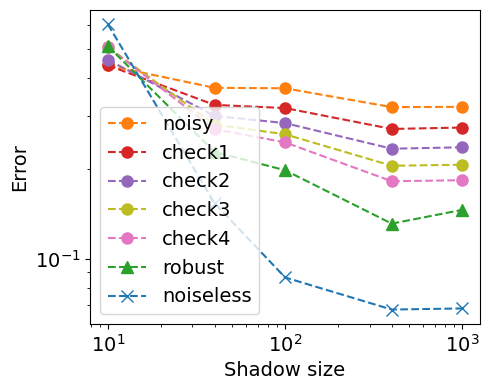

In [48]:
plt.figure(figsize=(5, 4), dpi=100)
plt.plot(shadow_range, error, '--o', ms=8, color='tab:orange', label='noisy')
plt.plot(shadow_range, error_check1, '--o', ms=8, color='tab:red', label='check1')
plt.plot(shadow_range, error_check2, '--o', ms=8, color='tab:purple', label='check2')
plt.plot(shadow_range, error_check3, '--o', ms=8, color='tab:olive', label='check3')
plt.plot(shadow_range, error_check4, '--o', ms=8, color='tab:pink', label='check4')
plt.plot(shadow_range, error_r, '--^', ms=8, color='tab:green', label='robust')
plt.plot(shadow_range, error_noiseless, '--x', ms=8, color='tab:blue', label='noiseless')
plt.legend(fontsize=14, loc='best')
plt.xlabel('Shadow size', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

In [49]:
# plt.figure(figsize=(5, 4), dpi=100)
# plt.plot(shadow_range, error, '--o', ms=8, color='tab:blue', label='Robust Shadow')
# plt.legend(fontsize=14, loc='best')
# plt.xlabel('Shadow size', fontsize=14)
# plt.ylabel('Error', fontsize=14)
# plt.xscale('log')
# plt.yscale('log')
# plt.tick_params(labelsize=14)
# plt.tight_layout()
# plt.show()

#### III. Perform the Pauli Check experiment